In [148]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [149]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import six
import glob
from stompy.plot import nbviz

In [156]:
# run_wy2022_bloom_common_20220810:
#   dye1, oakland release, non-temp hydro
# run_wy2022_bloom_common_20220810-v001
#   oakland, eastshore releases. temp hydro.
# run_wy2022_bloom_common_20220810-v002
#   oakland release, temp hydro, 16.62 integration
# run_wy2022_bloom_common_20220810-v003"
#   oakland release in top 2m of water column
# run_wy2022_bloom_common_20220515-v002
#   testing custom tracer
# run_wy2022_bloom_common_20220810-v007
#   age and depth tracers
run_dir="run_wy2022_bloom_common_20220810-v007" 

In [165]:
ds=xr.open_dataset(os.path.join(run_dir,"dwaq_map.nc"))

In [166]:
ds

<xarray.Dataset>
Dimensions:     (sub: 7, time: 623, layer: 10, face: 49996, node: 44184,
                 maxnode_per_face: 6, edge: 94194, node_per_edge: 2)
Coordinates:
  * sub         (sub) object 'oakland' 'Age1Conc' ... 'SURF' 'TotalDepth'
  * time        (time) datetime64[ns] 2022-08-10 ... 2022-08-22T23:00:00
Dimensions without coordinates: layer, face, node, maxnode_per_face, edge,
                                node_per_edge
Data variables: (12/16)
    t_sec       (time) int32 ...
    oakland     (time, layer, face) float32 ...
    Age1Conc    (time, layer, face) float32 ...
    Age1AConc   (time, layer, face) float32 ...
    Age1DAConc  (time, layer, face) float32 ...
    LocalDepth  (time, layer, face) float32 ...
    ...          ...
    node_y      (node) float64 ...
    face_node   (face, maxnode_per_face) int32 ...
    edge_node   (edge, node_per_edge) int32 ...
    bedlevel    (face) float32 ...
    eta         (time, face) float32 ...
    sigma       (layer) float64 ...
Attributes:
    header:   DWAQ                                    n/a                    ...

In [168]:
# post process to get
cmin=1e-8
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

# This would be better as an operator, but can fake it with 
# dask arrays to at least be lazy about evaluation.
# Hmm - not that easy I guess. Still quite slow.
#ds['Age'] = ratio( ds['Age1AConc'],ds['Age1Conc'])
#ds['AvgDepth'] = ratio( ds['Age1DAConc'],ds['Age1AConc'])

# Don't have Expressions yet
# add some static shots for testing
tidx=-1
layer=0
conc=ds['Age1Conc'].isel(time=tidx,layer=layer)
age_conc=ds['Age1AConc'].isel(time=tidx,layer=layer)
age_depth_conc=ds['Age1DAConc'].isel(time=tidx,layer=layer)
ds['mean_age']=ratio(age_conc,conc)
ds['mean_depth']=ratio(age_depth_conc, age_conc)

<IPython.core.display.Javascript object>


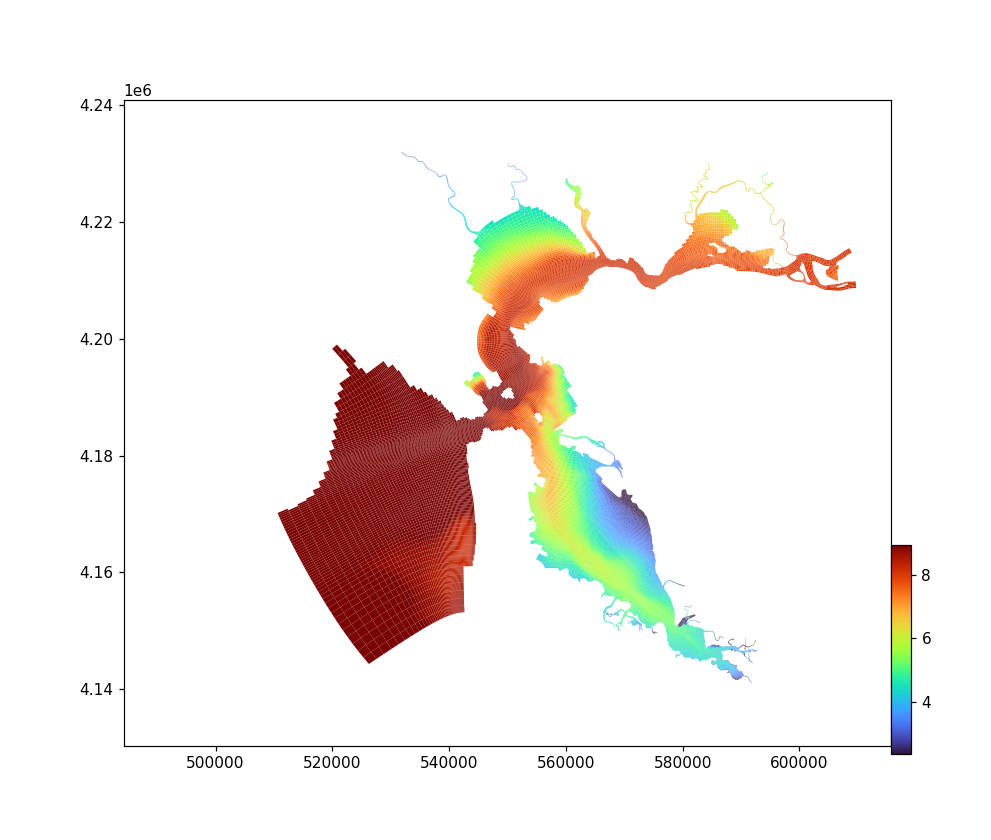

NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

set_variable:  mean_depth


In [169]:
six.moves.reload_module(nbviz)
viz=nbviz.NBViz([ds])
viz

In [172]:
(ds.time.values[-1] - ds.time.values[0])/np.timedelta64(1,'D')

12.958333333333334

In [127]:
six.moves.reload_module(unstructured_grid)
g=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

In [128]:
Mcell_to_node=g.interp_cell_to_node_matrix()

<IPython.core.display.Javascript object>


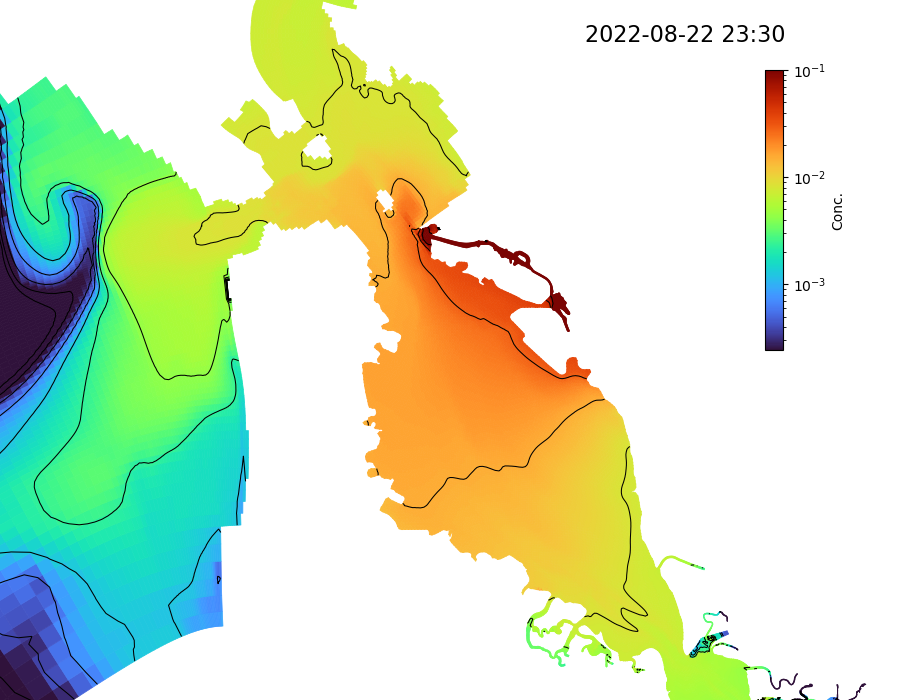

In [130]:
# pretty sure that with dwaq output, layer 0 is the surface, and LocalDepth
# is positive down
zoom=(525166.5357195626, 595636.7532705697, 4147408.0927562183, 4202218.261962557)

tracer='oakland'
contours=True

fig,ax=plt.subplots(figsize=(9,7))
ax.axis('off')
ax.set_adjustable('datalim')
cax=fig.add_axes([0.85,0.5,0.02,0.4])
# Figure an upper bound doubling every 24h, and the run is about
# 12 days long. so concentration below 1/2^12 is negligible. i.e.
# 
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ccoll=g.plot_cells(values=np.ones(g.Ncells()),cmap='turbo',ax=ax,
                   norm=colors.LogNorm(vmin=0.5**12,vmax=0.1,clip=True))
plt.setp(ccoll,edgecolors='face',lw=0.5)

plt.colorbar(ccoll,label='Conc.',cax=cax)
txt=ax.text(0.65,0.94,"",transform=ax.transAxes,fontsize=16)
ax.axis(zoom)

def update(tidx):
    scal=ds[tracer].isel(time=tidx,layer=0)
    ccoll.set_array(scal)
    date_str=ds.time.isel(time=tidx).dt.strftime("%Y-%m-%d %H:%M").item()
    txt.set_text(date_str)

    if contours:
        del ax.collections[1:] # hack
        levels=np.logspace(np.log10(1e-4),np.log10(1e-1),12)
        scal_node=Mcell_to_node.dot(scal)
        scal_node=np.where(np.isnan(scal_node),0,scal_node)
        cset=g.contour_node_values(scal_node,levels,ax=ax,colors='k',
                                   linewidths=0.75)   
    
update(200)

In [131]:
# Save frames for an animation
frame_dir=os.path.join(run_dir,f'frames-{tracer}-v0')
movie_fn=os.path.join(frame_dir,'movie.mp4')

In [132]:
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
for f in glob.glob(os.path.join(frame_dir,'*.png')):
    os.unlink(f)
for tidx in range(ds.dims['time']):
    update(tidx)
    fig.savefig(os.path.join(frame_dir,f"frame-{tidx:04}.png"))

In [122]:
# Compile to animation
subprocess.run(f"ffmpeg -framerate 16 -i {os.path.join(frame_dir,'frame-%04d.png')} "
                "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
               f"-pix_fmt yuv420p -crf 20 -r 16 {movie_fn}",
               shell=True)
                
               

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args='ffmpeg -framerate 16 -i run_wy2022_bloom_common_20220810-v001/frames-eastshore-v1/frame-%04d.png -c:v libx264 -preset slow -profile:v high -level:v 4.0 -pix_fmt yuv420p -crf 20 -r 16 run_wy2022_bloom_common_20220810-v001/frames-eastshore-v1/movie.mp4', returncode=0)

In [123]:
movie_fn

'run_wy2022_bloom_common_20220810-v001/frames-eastshore-v1/movie.mp4'

In [124]:
Video(movie_fn)
